<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S6/tweets_dataset_torchtext_0.9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and Cleaning - tweets dataset

In [1]:
!pip install tweet-preprocessor --quiet

In [114]:
import torchtext
torchtext.__version__

'0.9.1'

**Make sure you download the tweets dataset - (csv file) and store it in colab runtime.**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/tweets.csv')
df.head(5)

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [4]:
print('Total shape : ', df.shape)
print('Columns containing Hashtags : ', df[df['tweets'].str.contains('#')].shape)

Total shape :  (1364, 2)
Columns containing Hashtags :  (465, 2)


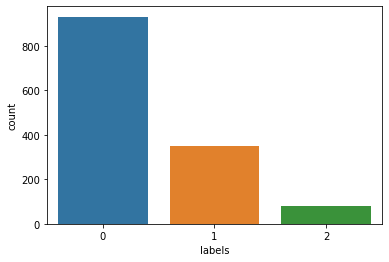

In [5]:
sns.countplot(x = 'labels', data=df)

When searched about on internet about preprocessing, it is found that the most relevant library to pre-process tweets data is `tweet-preprocessor`.

It deals with —

- URLs
- Mentions
- Reserved words (RT, FAV)
- Emojis
- Smileys

In [6]:
import preprocessor as p

for i,v in enumerate(df['tweets']):
    df.loc[i,'tweets_clean'] = p.clean(v)

In [7]:
df['tweets_clean'] = df['tweets_clean'].str.replace(':', '')
df

,tweets,labels,tweets_clean
0,Obama has called the GOP budget social Darwini...,1,Obama has called the GOP budget social Darwini...
1,"In his teen years, Obama has been known to use...",0,"In his teen years, Obama has been known to use..."
2,IPA Congratulates President Barack Obama for L...,0,IPA Congratulates President Barack Obama for L...
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0,- his connection to supporters of Critical Ra...
4,RT @wardollarshome: Obama has approved more ta...,1,Obama has approved more targeted assassinatio...
...,...,...,...
1359,@liberalminds Its trending idiot.. Did you loo...,0,Its trending idiot.. Did you look at the tweet...
1360,RT @AstoldByBass: #KimKardashiansNextBoyfriend...,0,Barack Obama
1361,RT @GatorNation41: gas was $1.92 when Obama to...,1,gas was $1.92 when Obama took office...I gues...
1362,"@xShwag haha i know im just so smart, i mean y...",1,"haha i know im just so smart, i mean you gotta..."


(-0.5, 399.5, 199.5, -0.5)

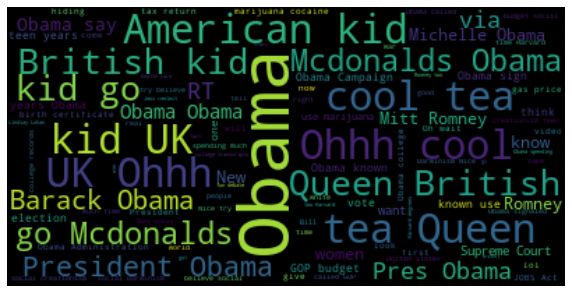

In [8]:
from wordcloud import WordCloud
tweet_All = " ".join(review for review in df['tweets_clean'])

fig, ax = plt.subplots(1, 1, figsize  = (10,10))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')

In [9]:
df.to_csv('tweets_clean.csv')

In [10]:
df.dtypes

tweets          object
labels           int64
tweets_clean    object
dtype: object

# Dataframe --> torch dataset --> torch Dataloader

### Not using the torchtext.legacy API

In [54]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split

from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

In [85]:
class TweetsDataset(Dataset):

    def __init__(self, path):
        super(self.__class__, self).__init__()

        self.df = pd.read_csv(path)
        self.df = self.df[~self.df['tweets_clean'].isna()].reset_index(drop=True)

        self.text_transform = lambda x: [self.vocab['<BOS>']] + [self.vocab[token] for token in self.tokenizer(x)] + [self.vocab['<EOS>']]
        # self.label_transform = 

        self.set_tokeniser()
        self.vocab = self.build_vocab()
        print("Done.")

    def __getitem__(self, idx):
        tweet = self.df['tweets_clean'].iloc[idx]
        label = self.df['labels'].iloc[idx]
        return label, tweet 

    def __len__(self):
        return len(self.df)

    def set_tokeniser(self, name='spacy', language='en_core_web_sm'):
        print(f"Tokenizer set : {name}")
        self.tokenizer = get_tokenizer(name, language=language)

    def build_vocab(self):
        print("Building Vocab ..")
        train_iter = list(self.df[['labels', 'tweets_clean']].to_records(index=False))
        counter = Counter()
        for (label, line) in train_iter:
            counter.update(self.tokenizer(line))
        vocab = Vocab(counter, min_freq=2, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))
        return vocab

    @property
    def collate_fn(self):
        def collate_batch(batch):
            label_list, text_list, length_list = [], [], []
            pad_idx = dataset.vocab['<pad>']

            for (_label, _text) in batch:
                label_list.append(_label)

                processed_text = torch.tensor(text_transform(_text))
                text_list.append(processed_text)

                length_list.append(len(processed_text))

            labels = torch.tensor(label_list)
            texts = pad_sequence(text_list, padding_value=pad_idx, batch_first=True)
            lengths = torch.LongTensor(length_list)
            return labels, texts, lengths
        return collate_batch

In [91]:
dataset = TweetsDataset('/content/tweets_clean.csv')

Tokenizer set : spacy
Building Vocab ..
Done.


In [92]:
print("The length of the new vocab is", len(dataset.vocab))
new_stoi = dataset.vocab.stoi
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = dataset.vocab.itos
print("The token at index 2 is", new_itos[2])
print("The most common words ", dataset.vocab.freqs.most_common(10))

The length of the new vocab is 1826
The index of '<BOS>' is 1
The token at index 2 is <EOS>
The most common words  [('Obama', 1188), ('.', 897), (',', 707), ('"', 647), ('the', 620), (' ', 607), ('?', 479), ('to', 472), ("'s", 349), ('of', 283)]


# Splitting dataset and Making Data loaders

In [93]:
len(dataset)

1351

In [95]:
def make_me_splits(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

In [96]:
train_dataset, test_dataset = make_me_splits(dataset)
print("Length of train set : ", len(train_dataset))
print("Length of train set : ", len(test_dataset))

Length of train set :  1080
Length of train set :  271


## Making Dataloaders
### Only difference b/w Dataloader and Bucketiterator is that these dont support sorting by length inside batches

In [100]:
dataset.collate_fn

<function __main__.TweetsDataset.collate_fn.<locals>.collate_batch>

In [105]:
def train_dataloader(dataset):
    loader = DataLoader(
        dataset,
        batch_size=2,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=dataset.collate_fn
    )
    return loader

In [109]:
my_loader = train_dataloader(dataset)

In [110]:
my_loader_iter = iter(my_loader)
next(my_loader_iter)

(tensor([0, 0]),
 tensor([[   1,    9,  989,    4,  954,  498,  128,  861,  876,   80, 1182,  148,
           701,  563, 1355,  171,  232,  284,    2,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0],
         [   1,    9,   40,   23,    7,   36,   39,   30,    8,   50,   10,   49,
            43,    6,   37,   31,   15,   33,   52,   17,    8,   51,   10,    7,
             5,   47,   23,    7,   41,   15,   29,    6,   38,   11,   48,   17,
             4,   10,    2]]),
 tensor([19, 39]))

In [111]:
next(my_loader_iter)

(tensor([0, 1]),
 tensor([[   1,  100,  296, 1323, 1213,   44,  138,  791,  147,   58,    4,    2,
             0,    0,    0],
         [   1,  921,    9,    4,   12,  448, 1631,    0,    0,    0,   11,    0,
            20,   19,    2]]),
 tensor([12, 15]))

---

----------

# ************ Misc ************

In [42]:
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    pad_idx = dataset.vocab['<pad>']

    for (_label, _text) in batch:
        label_list.append(_label)

        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)

        length_list.append(len(processed_text))

    labels = torch.tensor(label_list)
    texts = pad_sequence(text_list, padding_value=pad_idx, batch_first=True)
    lengths = torch.LongTensor(length_list)

    return labels, texts, lengths

In [43]:
collate_batch((dataset[0],dataset[1]))

(tensor([1, 0]),
 tensor([[  1,   4,  44, 199,   8,  70, 108,  97, 207,   5, 195, 228,   6,  65,
           92, 115,  20,  97, 220,   5,   2],
         [  1,  80,  32, 162,  69,   6,   4,  44, 107, 152,  11, 127, 160,  21,
          159,   5,   2,   0,   0,   0,   0]]),
 tensor([21, 17]))

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
   label_list, text_list = [], []
   for (_label, _text) in batch:
        label_list.append(label_transform(_label))

        processed_text = torch.tensor(text_transform(_text))
        
        text_list.append(processed_text)

   return torch.tensor(label_list), pad_sequence(text_list, padding_value=3.0)

train_iter = IMDB(split='train')
train_dataloader = DataLoader(list(train_iter), batch_size=8, shuffle=True, 
                              collate_fn=collate_batch)

---